In [1]:
%pip install pandas --quiet
%pip install xgboost scikit-learn matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
# Read in the complete data
complete_data_df = pd.read_csv('../../data/processed/complete_data.csv')

In [4]:
# Use features that are available in our split dataset
# We need to work with the complete_data_df instead of the limited selected_data_with_date
print("\nAll available columns in complete_data_df:")
print(complete_data_df.columns.tolist())

# Re-create train/test split with all features
complete_data_df['datetime_au'] = pd.to_datetime(complete_data_df['datetime_au'])
complete_data_df['year'] = complete_data_df['datetime_au'].dt.year

# Split data into training (2016-2018) and testing (2019) with all features
train_data_full = complete_data_df[complete_data_df['year'].isin([2016, 2017, 2018])].copy()
test_data_full = complete_data_df[complete_data_df['year'] == 2019].copy()

# Enhanced feature selection using all available features
feature_columns = [
    'is_weekend', 'is_weekday', 'avg_temp', 'min_temp', 'max_temp',
    'is_summer', 'is_autumn', 'is_winter', 'is_spring',
    'is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday', 'is_saturday', 'is_sunday',
    'precipitation', 'sunlight', 'hd_next_24h', 'cd_next_24h',
    'is_jan', 'is_feb', 'is_mar', 'is_apr', 'is_may', 'is_jun',
    'is_jul', 'is_aug', 'is_sep', 'is_oct', 'is_nov', 'is_dec'
]

target_column = 'sum_30_min_demand'

# Prepare training data (2016-2018)
X_train = train_data_full[feature_columns].copy()
y_train = train_data_full[target_column].copy()

# Prepare test data (2019)
X_test = test_data_full[feature_columns].copy()
y_test = test_data_full[target_column].copy()



All available columns in complete_data_df:
['datetime_au', 'is_summer', 'is_autumn', 'is_winter', 'is_spring', 'is_sunday', 'is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday', 'is_saturday', 'is_weekend', 'is_weekday', 'is_jan', 'is_feb', 'is_mar', 'is_apr', 'is_may', 'is_jun', 'is_jul', 'is_aug', 'is_sep', 'is_oct', 'is_nov', 'is_dec', 'avg_30_min_demand', 'min_30_min_demand', 'max_30_min_demand', 'sum_30_min_demand', 'count_30_min_points', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'precipitation', 'sunlight']


In [14]:
# Model 1: Original data (no normalization)
xgb_original = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1,
    n_jobs=-1
)

xgb_original.fit(X_train, y_train)
y_train_pred_orig = xgb_original.predict(X_train)
y_test_pred_orig = xgb_original.predict(X_test)

In [15]:
def evaluate_model(y_true, y_pred, dataset_name):
    """Calculate and display model evaluation metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = float(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
    
    return {'RMSE': rmse, 'MAE': mae, 'R²': r2, 'MAPE': mape}

# Evaluate original model
train_metrics_orig = evaluate_model(y_train, y_train_pred_orig, "Train")
test_metrics_orig = evaluate_model(y_test, y_test_pred_orig, "Test")
print("\nOriginal Model Performance:")
print(f"Train Metrics: {train_metrics_orig}")
print(f"Test Metrics: {test_metrics_orig}")


Original Model Performance:
Train Metrics: {'RMSE': 4739.449155816782, 'MAE': 3435.8892944038935, 'R²': 0.9822868761224965, 'MAPE': 0.9080379477887393}
Test Metrics: {'RMSE': 15147.039855208297, 'MAE': 10208.852416666667, 'R²': 0.836286280780473, 'MAPE': 2.6689682878705216}


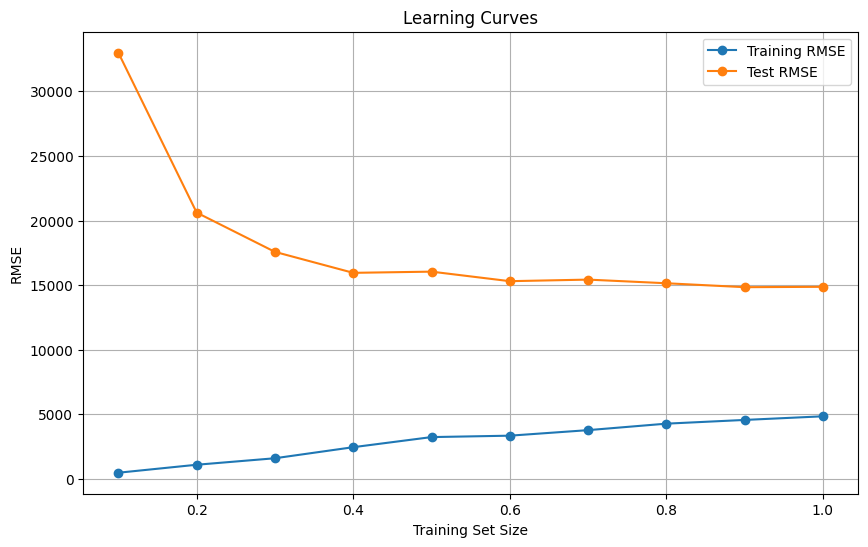

In [13]:
def plot_learning_curves(model, X_train, y_train, X_test, y_test):
    """Plot learning curves to visualize overfitting"""
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_rmse = []
    test_rmse = []
    
    for size in train_sizes:
        sample_size = int(len(X_train) * size)
        X_sample = X_train[:sample_size]
        y_sample = y_train[:sample_size]
        
        model.fit(X_sample, y_sample)
        
        train_pred = model.predict(X_sample)
        test_pred = model.predict(X_test)
        
        train_rmse.append(np.sqrt(mean_squared_error(y_sample, train_pred)))
        test_rmse.append(np.sqrt(mean_squared_error(y_test, test_pred)))
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_rmse, 'o-', label='Training RMSE')
    plt.plot(train_sizes, test_rmse, 'o-', label='Test RMSE')
    plt.xlabel('Training Set Size')
    plt.ylabel('RMSE')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curves(xgb_original, X_train, y_train, X_test, y_test)

In [16]:
def evaluate_model_comprehensive(model, X_train, y_train, X_test, y_test, model_name):
    """Enhanced evaluation to detect overfitting"""
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_metrics = evaluate_model(y_train, y_train_pred, "Train")
    test_metrics = evaluate_model(y_test, y_test_pred, "Test")
    
    # Check for overfitting indicators
    overfitting_score = test_metrics['RMSE'] / train_metrics['RMSE']
    r2_gap = train_metrics['R²'] - test_metrics['R²']
    
    print(f"\n{model_name} Performance:")
    print(f"Train RMSE: {train_metrics['RMSE']:.2f}")
    print(f"Test RMSE:  {test_metrics['RMSE']:.2f}")
    print(f"Train R²:   {train_metrics['R²']:.4f}")
    print(f"Test R²:    {test_metrics['R²']:.4f}")
    print(f"Overfitting Score: {overfitting_score:.3f} (closer to 1.0 is better)")
    print(f"R² Gap: {r2_gap:.4f} (smaller is better)")
    
    if overfitting_score > 1.2 or r2_gap > 0.1:
        print("⚠️  Potential overfitting detected!")
    else:
        print("✅ No significant overfitting detected")
    
    return train_metrics, test_metrics

evaluate_model_comprehensive(xgb_original, X_train, y_train, X_test, y_test, "Original XGBoost Model")  


Original XGBoost Model Performance:
Train RMSE: 4739.45
Test RMSE:  15147.04
Train R²:   0.9823
Test R²:    0.8363
Overfitting Score: 3.196 (closer to 1.0 is better)
R² Gap: 0.1460 (smaller is better)
⚠️  Potential overfitting detected!


({'RMSE': 4739.449155816782,
  'MAE': 3435.8892944038935,
  'R²': 0.9822868761224965,
  'MAPE': 0.9080379477887393},
 {'RMSE': 15147.039855208297,
  'MAE': 10208.852416666667,
  'R²': 0.836286280780473,
  'MAPE': 2.6689682878705216})

### 1. Cross-Validation with Early Stopping

In [46]:
# Add cross-validation with early stopping
from sklearn.model_selection import cross_val_score

# Split your training data into train/validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=1, shuffle=False  # Don't shuffle for time series
)

# XGBoost with early stopping
xgb_model = xgb.XGBRegressor(
    n_estimators=100,  # Start with more estimators
    max_depth=6,        # Reduce depth
    learning_rate=0.1, # Lower learning rate
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1,
    early_stopping_rounds=50,  # Stop if no improvement for 20 rounds
    n_jobs=-1
)

# Fit with validation set
xgb_model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val_split, y_val_split)],
    verbose=False
)

# Predict and evaluate
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)
train_metrics = evaluate_model(y_train, y_train_pred, "Train")
test_metrics = evaluate_model(y_test, y_test_pred, "Test")
print("\nTuned Model Performance:")
print(f"Train Metrics: {train_metrics}")
print(f"Test Metrics: {test_metrics}")

evaluate_model_comprehensive(xgb_model, X_train, y_train, X_test, y_test, "Tuned XGBoost Model")


Tuned Model Performance:
Train Metrics: {'RMSE': 10647.912463574445, 'MAE': 7459.205301475062, 'R²': 0.9105936496278951, 'MAPE': 1.9726474907262543}
Test Metrics: {'RMSE': 16219.760330484669, 'MAE': 11339.26705022831, 'R²': 0.8122766033081265, 'MAPE': 2.996029284490738}

Tuned XGBoost Model Performance:
Train RMSE: 10647.91
Test RMSE:  16219.76
Train R²:   0.9106
Test R²:    0.8123
Overfitting Score: 1.523 (closer to 1.0 is better)
R² Gap: 0.0983 (smaller is better)
⚠️  Potential overfitting detected!


({'RMSE': 10647.912463574445,
  'MAE': 7459.205301475062,
  'R²': 0.9105936496278951,
  'MAPE': 1.9726474907262543},
 {'RMSE': 16219.760330484669,
  'MAE': 11339.26705022831,
  'R²': 0.8122766033081265,
  'MAPE': 2.996029284490738})

In [ ]:
# Model with stronger regularization
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=4,           # Reduce tree depth
    learning_rate=0.05,    # Lower learning rate
    subsample=0.8,         # More aggressive subsampling
    colsample_bytree=0.8,  # Feature subsampling
    reg_alpha=1.0,         # L1 regularization
    reg_lambda=1.0,        # L2 regularization
    min_child_weight=5,    # Minimum samples in leaf
    gamma=0.1,             # Minimum split loss
    random_state=1,
    early_stopping_rounds=50,  # Stop if no improvement for 50 rounds
    n_jobs=-1
)


## 2. Hyperparameter Tuning

In [5]:
# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [2, 4, 6, 8, 10],
    'learning_rate': [0.02, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}

# Initialize variables to track best model
best_model = None
best_params = None
best_test_mape = float('inf')
best_test_r2 = -float('inf')
results = []

# Calculate total combinations
import itertools
total_combinations = len(list(itertools.product(*param_grid.values())))
print(f"Total parameter combinations to test: {total_combinations}")

# Loop through all parameter combinations
combination_count = 0
for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for learning_rate in param_grid['learning_rate']:
            for subsample in param_grid['subsample']:
                for colsample_bytree in param_grid['colsample_bytree']:
                    combination_count += 1
                    
                    # Create model with current parameters
                    model = xgb.XGBRegressor(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        subsample=subsample,
                        colsample_bytree=colsample_bytree,
                        random_state=1,
                        n_jobs=-1
                    )
                    
                    # Fit the model
                    model.fit(X_train, y_train)
                    
                    # Make predictions
                    y_train_pred = model.predict(X_train)
                    y_test_pred = model.predict(X_test)
                    
                    # Calculate all metrics
                    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
                    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
                    train_mae = mean_absolute_error(y_train, y_train_pred)
                    test_mae = mean_absolute_error(y_test, y_test_pred)
                    train_r2 = r2_score(y_train, y_train_pred)
                    test_r2 = r2_score(y_test, y_test_pred)
                    train_mape = float(np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100)
                    test_mape = float(np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100)
                    
                    # Store results
                    result = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'learning_rate': learning_rate,
                        'subsample': subsample,
                        'colsample_bytree': colsample_bytree,
                        'train_rmse': train_rmse,
                        'test_rmse': test_rmse,
                        'train_mae': train_mae,
                        'test_mae': test_mae,
                        'train_r2': train_r2,
                        'test_r2': test_r2,
                        'train_mape': train_mape,
                        'test_mape': test_mape
                    }
                    results.append(result)
                    
                    # Check if this is the best model based on test MAPE (lower is better)
                    if test_mape < best_test_mape:
                        best_test_mape = test_mape
                        best_test_r2 = test_r2
                        best_model = model
                        best_params = {
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'learning_rate': learning_rate,
                            'subsample': subsample,
                            'colsample_bytree': colsample_bytree
                        }
                    
                    # Print progress every 100 combinations
                    if combination_count % 100 == 0 or combination_count == total_combinations:
                        print(f"Completed {combination_count}/{total_combinations} combinations")

print("\n" + "="*50)
print("HYPERPARAMETER TUNING COMPLETE")
print("="*50)
print(f"\nBest parameters: {best_params}")
print(f"Best test MAPE: {best_test_mape:.2f}%")
print(f"Best test R²: {best_test_r2:.4f}")

# Use the best model for final predictions
y_train_pred_orig = best_model.predict(X_train)
y_test_pred_orig = best_model.predict(X_test)

Total parameter combinations to test: 1600
Completed 100/1600 combinations
Completed 100/1600 combinations
Completed 200/1600 combinations
Completed 200/1600 combinations
Completed 300/1600 combinations
Completed 300/1600 combinations
Completed 400/1600 combinations
Completed 400/1600 combinations
Completed 500/1600 combinations
Completed 500/1600 combinations
Completed 600/1600 combinations
Completed 600/1600 combinations
Completed 700/1600 combinations
Completed 700/1600 combinations
Completed 800/1600 combinations
Completed 800/1600 combinations


KeyboardInterrupt: 

In [6]:
# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Sort by test MAPE (lower is better)
results_df_sorted = results_df.sort_values('test_mape').reset_index(drop=True)

# Display top 10 best parameter combinations
print("Top 10 Best Parameter Combinations (by Test MAPE):")
print("="*80)
for i in range(min(10, len(results_df_sorted))):
    row = results_df_sorted.iloc[i]
    print(f"Rank {i+1}:")
    print(f"  Parameters: n_estimators={row['n_estimators']}, max_depth={row['max_depth']}, "
          f"learning_rate={row['learning_rate']}, subsample={row['subsample']}, "
          f"colsample_bytree={row['colsample_bytree']}")
    print(f"  Test Metrics:  MAPE={row['test_mape']:.2f}%, RMSE={row['test_rmse']:.2f}, "
          f"MAE={row['test_mae']:.2f}, R²={row['test_r2']:.4f}")
    print(f"  Train Metrics: MAPE={row['train_mape']:.2f}%, RMSE={row['train_rmse']:.2f}, "
          f"MAE={row['train_mae']:.2f}, R²={row['train_r2']:.4f}")
    print()

# Display comprehensive statistics for all metrics
print("\nDetailed Parameter Search Statistics:")
print("="*40)

print("\nMAPE Statistics:")
print("-" * 16)
print(f"Best Test MAPE:   {results_df_sorted['test_mape'].min():.2f}%")
print(f"Worst Test MAPE:  {results_df_sorted['test_mape'].max():.2f}%")
print(f"Mean Test MAPE:   {results_df_sorted['test_mape'].mean():.2f}%")
print(f"Median Test MAPE: {results_df_sorted['test_mape'].median():.2f}%")
print(f"Std Test MAPE:    {results_df_sorted['test_mape'].std():.2f}%")
print(f"MAPE Range:       {results_df_sorted['test_mape'].max() - results_df_sorted['test_mape'].min():.2f}% points")

print("\nRMSE Statistics:")
print("-" * 16)
print(f"Best Test RMSE:   {results_df_sorted['test_rmse'].min():.2f}")
print(f"Worst Test RMSE:  {results_df_sorted['test_rmse'].max():.2f}")
print(f"Mean Test RMSE:   {results_df_sorted['test_rmse'].mean():.2f}")
print(f"Median Test RMSE: {results_df_sorted['test_rmse'].median():.2f}")
print(f"Std Test RMSE:    {results_df_sorted['test_rmse'].std():.2f}")

print("\nMAE Statistics:")
print("-" * 15)
print(f"Best Test MAE:    {results_df_sorted['test_mae'].min():.2f}")
print(f"Worst Test MAE:   {results_df_sorted['test_mae'].max():.2f}")
print(f"Mean Test MAE:    {results_df_sorted['test_mae'].mean():.2f}")
print(f"Median Test MAE:  {results_df_sorted['test_mae'].median():.2f}")
print(f"Std Test MAE:     {results_df_sorted['test_mae'].std():.2f}")

print("\nR² Statistics:")
print("-" * 14)
print(f"Best Test R²:     {results_df_sorted['test_r2'].max():.4f}")
print(f"Worst Test R²:    {results_df_sorted['test_r2'].min():.4f}")
print(f"Mean Test R²:     {results_df_sorted['test_r2'].mean():.4f}")
print(f"Median Test R²:   {results_df_sorted['test_r2'].median():.4f}")
print(f"Std Test R²:      {results_df_sorted['test_r2'].std():.4f}")

# Save the best model as xgb_original for compatibility with existing code
xgb_original = best_model

# Display best model's complete performance
print(f"\nBest Model (Rank 1) Complete Performance:")
print("="*45)
best_row = results_df_sorted.iloc[0]
print(f"Parameters: n_estimators={best_row['n_estimators']}, max_depth={best_row['max_depth']}, "
      f"learning_rate={best_row['learning_rate']}, subsample={best_row['subsample']}, "
      f"colsample_bytree={best_row['colsample_bytree']}")
print(f"Test Performance:  MAPE={best_row['test_mape']:.2f}%, RMSE={best_row['test_rmse']:.2f}, "
      f"MAE={best_row['test_mae']:.2f}, R²={best_row['test_r2']:.4f}")
print(f"Train Performance: MAPE={best_row['train_mape']:.2f}%, RMSE={best_row['train_rmse']:.2f}, "
      f"MAE={best_row['train_mae']:.2f}, R²={best_row['train_r2']:.4f}")

# Calculate overfitting indicators for best model
mape_gap = best_row['test_mape'] - best_row['train_mape']
rmse_ratio = best_row['test_rmse'] / best_row['train_rmse']
r2_gap = best_row['train_r2'] - best_row['test_r2']

print(f"\nOverfitting Analysis for Best Model:")
print("-" * 37)
print(f"MAPE Gap (Test - Train):     {mape_gap:.2f}% points")
print(f"RMSE Ratio (Test/Train):     {rmse_ratio:.3f}")
print(f"R² Gap (Train - Test):       {r2_gap:.4f}")

if rmse_ratio > 1.2 or r2_gap > 0.1:
    print("⚠️  Potential overfitting detected in best model!")
else:
    print("✅ No significant overfitting detected in best model")

Top 10 Best Parameter Combinations (by Test MAPE):
Rank 1:
  Parameters: n_estimators=100.0, max_depth=6.0, learning_rate=0.1, subsample=0.8, colsample_bytree=0.6
  Test Metrics:  MAPE=2.59%, RMSE=14502.65, MAE=9868.96, R²=0.8499
  Train Metrics: MAPE=0.93%, RMSE=4857.45, MAE=3537.27, R²=0.9814

Rank 2:
  Parameters: n_estimators=50.0, max_depth=6.0, learning_rate=0.15, subsample=0.7, colsample_bytree=0.6
  Test Metrics:  MAPE=2.59%, RMSE=14417.01, MAE=9875.18, R²=0.8517
  Train Metrics: MAPE=1.20%, RMSE=6373.09, MAE=4554.74, R²=0.9680

Rank 3:
  Parameters: n_estimators=100.0, max_depth=4.0, learning_rate=0.1, subsample=0.7, colsample_bytree=0.8
  Test Metrics:  MAPE=2.60%, RMSE=14645.52, MAE=9877.01, R²=0.8469
  Train Metrics: MAPE=1.56%, RMSE=8169.40, MAE=5925.91, R²=0.9474

Rank 4:
  Parameters: n_estimators=50.0, max_depth=4.0, learning_rate=0.2, subsample=0.6, colsample_bytree=0.8
  Test Metrics:  MAPE=2.60%, RMSE=14796.89, MAE=9898.23, R²=0.8438
  Train Metrics: MAPE=1.67%, RMSE